In [ ]:
pip install pandas numpy torch torchvision scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Load dataset
file_path = "/content/drive/MyDrive/Minor_project6thsem/Datasets/DDOS SDN TREE TORUS /SNT_dataset.csv"
df = pd.read_csv(file_path)

In [74]:
print(df['label'].value_counts())  # Check class distribution


label
0    527575
1    507093
Name: count, dtype: int64


In [99]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Handle Non-Numeric Columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
label_encoders = {col: LabelEncoder() for col in non_numeric_cols}
for col in non_numeric_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Remove rows where the target column ('label') has NaN
df = df.dropna(subset=['label'])

# Separate Features and Target
target_column = 'label'
X = df.drop(columns=[target_column])
y = df[target_column].astype(int)

# Ensure Class 1 Exists
print("\nClass Distribution Before Splitting:")
print(y.value_counts())

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data (Ensure balanced train/test sets)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Add Gaussian Noise to Training Data
X_train_noisy = X_train + np.random.normal(0, 0.01, X_train.shape)  # Small noise for generalization

# Ensure Balanced Train/Test Set
print("\nClass Distribution After Splitting:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_noisy, dtype=torch.float32)  # Use noisy data
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Class Distribution Before Splitting:
label
0    527575
1    507093
Name: count, dtype: int64

Class Distribution After Splitting:
label
0    369302
1    354965
Name: count, dtype: int64
label
0    158273
1    152128
Name: count, dtype: int64


In [109]:
class FedModel(nn.Module):
    def __init__(self, input_size):
        super(FedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)  # ⬇ Reduce neurons
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)  # ⬇ Reduce neurons
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.5)  # ⬆ Increase dropout

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)


In [110]:
num_clients = 5
X_train_split = np.array_split(X_train_noisy, num_clients)
y_train_split = np.array_split(y_train, num_clients)

client_datasets = []
for i in range(num_clients):
    X_tensor = torch.tensor(X_train_split[i], dtype=torch.float32)
    y_tensor = torch.tensor(y_train_split[i].to_numpy(), dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [111]:
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))], dim=0).mean(0)
    global_model.load_state_dict(global_state_dict)

def train_federated(global_model, client_loaders, epochs=3):  # ⬇ Reduce epochs to prevent overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # ⬆ Increase label smoothing
    client_models = [FedModel(input_size=X_train.shape[1]) for _ in range(num_clients)]
    optimizers = [optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) for model in client_models]  # ⬇ Reduce LR

    for epoch in range(epochs):
        for i in range(num_clients):
            client_models[i].load_state_dict(global_model.state_dict())
            client_models[i].train()
            epoch_loss = 0
            for X_batch, y_batch in client_loaders[i]:
                optimizers[i].zero_grad()
                outputs = client_models[i](X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizers[i].step()
                epoch_loss += loss.item()

        federated_averaging(global_model, client_models)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


In [112]:
# Initialize global model
global_model = FedModel(input_size=X_train.shape[1])

# Train the model with federated learning
train_federated(global_model, client_datasets, epochs=3)

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())

    # Accuracy Score
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(global_model, test_loader)


Epoch 1/3, Loss: 1558.0114
Epoch 2/3, Loss: 1299.0479
Epoch 3/3, Loss: 1141.9954
Accuracy: 0.9981

Confusion Matrix:
 [[158271      2]
 [   581 151547]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    158273
           1       1.00      1.00      1.00    152128

    accuracy                           1.00    310401
   macro avg       1.00      1.00      1.00    310401
weighted avg       1.00      1.00      1.00    310401



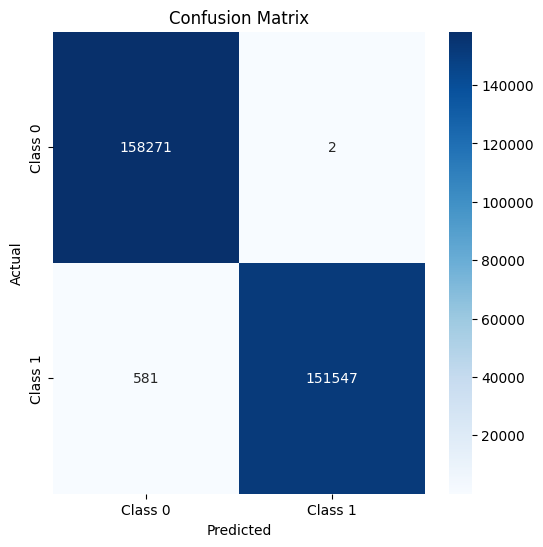

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


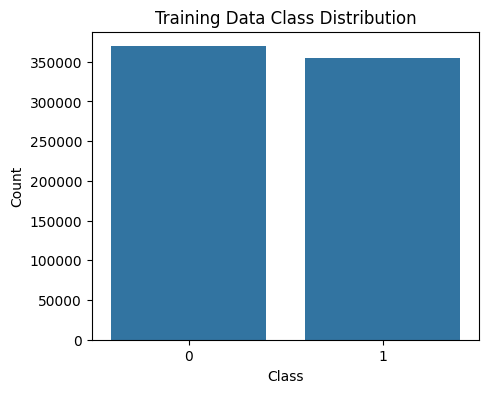

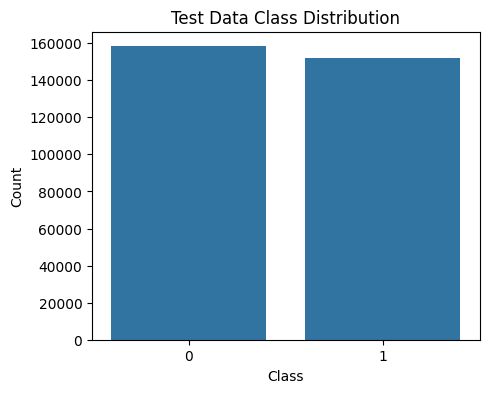

In [114]:
# Train Data Distribution
plt.figure(figsize=(5, 4))
sns.countplot(x=y_train)
plt.title("Training Data Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Test Data Distribution
plt.figure(figsize=(5, 4))
sns.countplot(x=y_test)
plt.title("Test Data Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


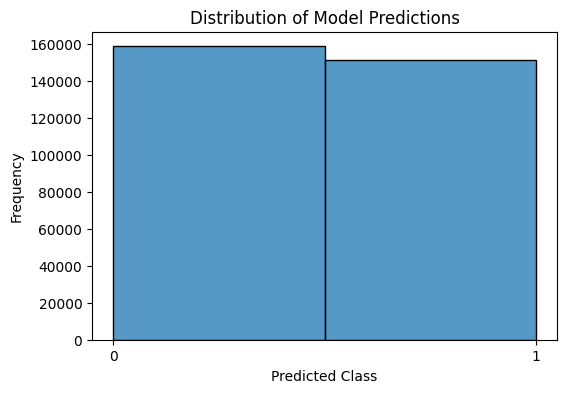

In [115]:
plt.figure(figsize=(6,4))
sns.histplot(y_pred, bins=2, kde=False)
plt.title("Distribution of Model Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.xticks([0, 1])
plt.show()



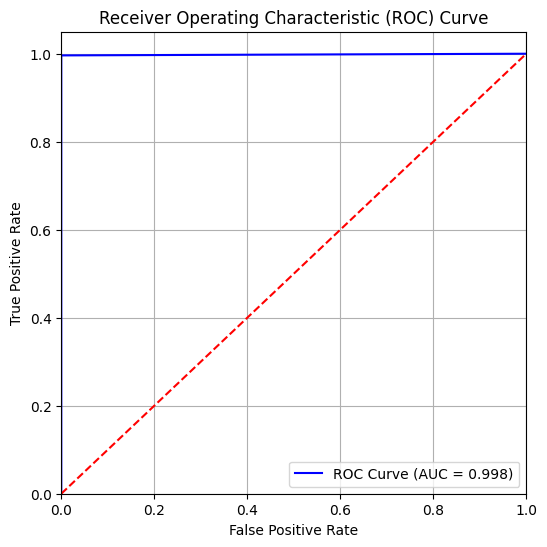

In [116]:
from sklearn.metrics import roc_curve, auc

# Convert predictions & true labels to numpy arrays
y_true_np = np.array(y_true)
y_pred_prob = np.array(y_pred)  # Assuming predictions are probabilities

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true_np, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random classifier baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


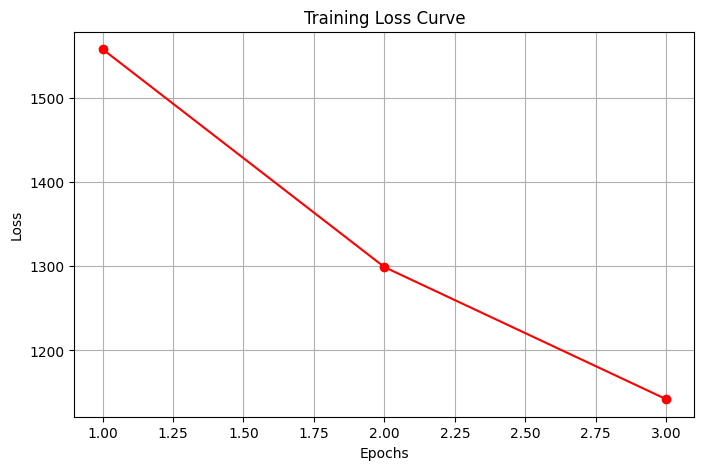

In [117]:
# Assuming loss values were stored in a list during training
epochs = [1, 2, 3]  # Update based on actual epochs
loss_values = [1558.0114, 1299.0479, 1141.9954]  # Update with actual loss values

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


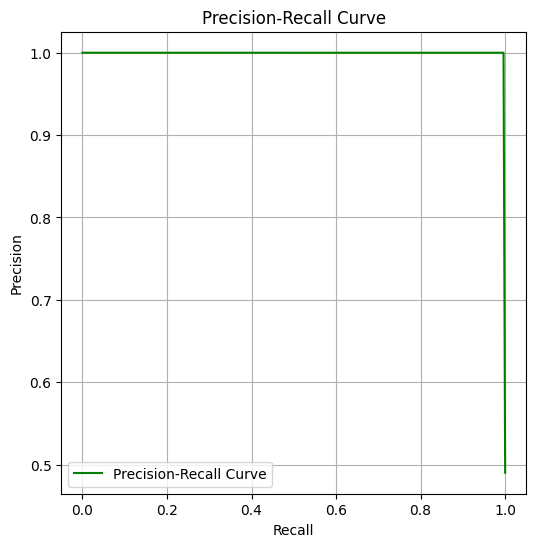

In [118]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true_np, y_pred_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
